In [145]:
import numpy as np
from glob import glob
import json
import pandas as pd
from bagle import model
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from mad_munge import getpriors
from importlib import reload

In [86]:
files = sorted(glob('../query_output*'))
file = files[-1]
print(file)
jdat = json.load(open(file))
print(jdat.keys())
events = sorted(jdat['ra'].keys())
date = file[16:20]+'_'+file[21:23]+'_'+file[24:26]
date

../query_output_2024-03-25.json
dict_keys(['ra', 'dec', 't0', 'tE', 'Ibase', 'photom_moa', 'photom_kmt', 'photom_ogle', 'data_sets'])


'2024_03_25'

In [71]:
param_names = ['t0','u0_amp','tE','piE_E','piE_N','b_sff1','mag_base1']
param_err_names = [n+'_err' for n in param_names]
colnames = np.reshape([[param_names[i],param_err_names[i]] for i in range(7)],-1)
dats = []
nmodes = []
for event in events:
    dir = event+'/fits_'+date+'/pspl_phot_par/'
    f_stats = dir+'b0_stats.dat'
    lines = open(f_stats).readlines()
    nmode = int(lines[5].split()[-1])
    nmodes.append(nmode)
    params = [float(lines[13+i].split()[1]) for i in range(7)]
    param_errs = [float(lines[13+i].split()[2]) for i in range(7)]
    dat = np.reshape([[params[i],param_errs[i]] for i in range(7)],-1)
    dats.append(dat)
dats = np.transpose(dats)
dict = {'events':events, 'nmodes':nmodes}
for i,col in enumerate(colnames):
    dict.update({col:dats[i]})
df = pd.DataFrame(dict)


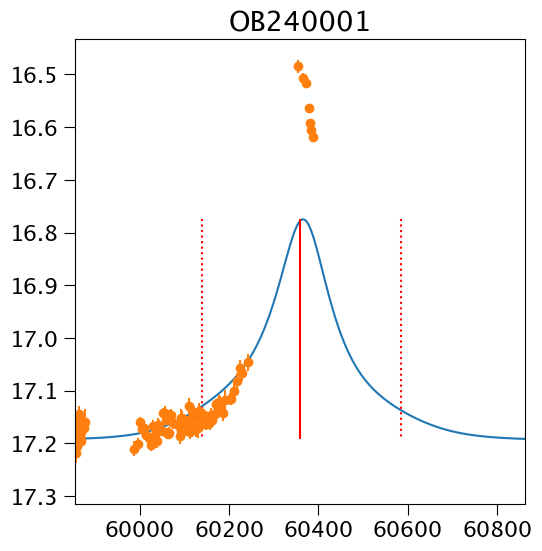

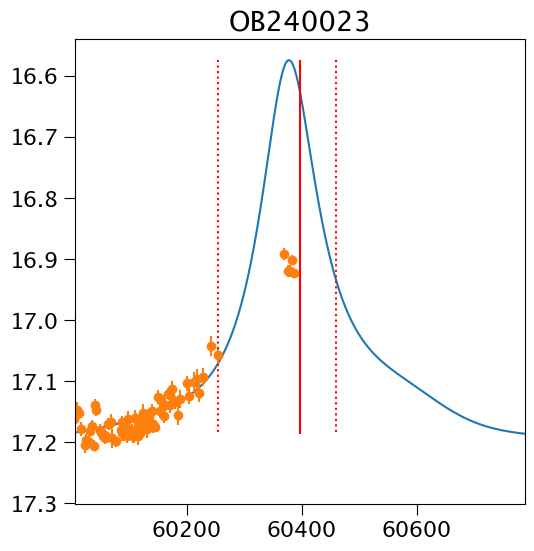

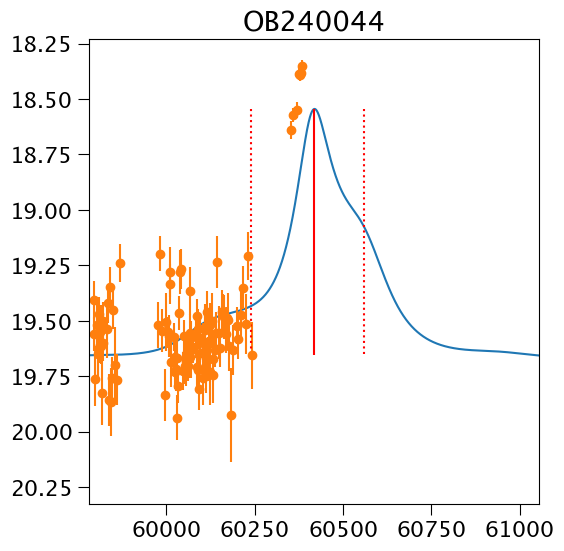

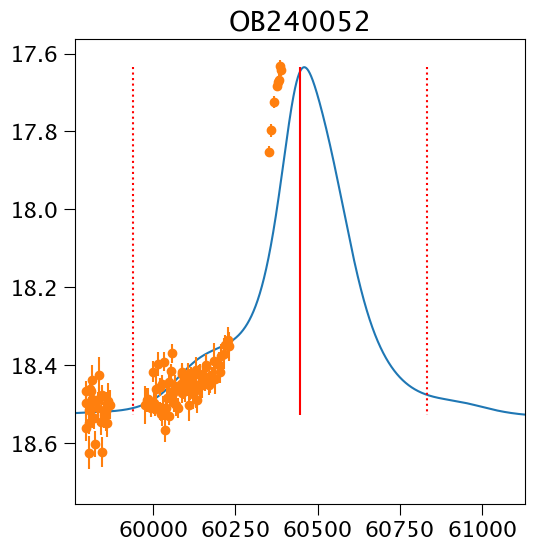

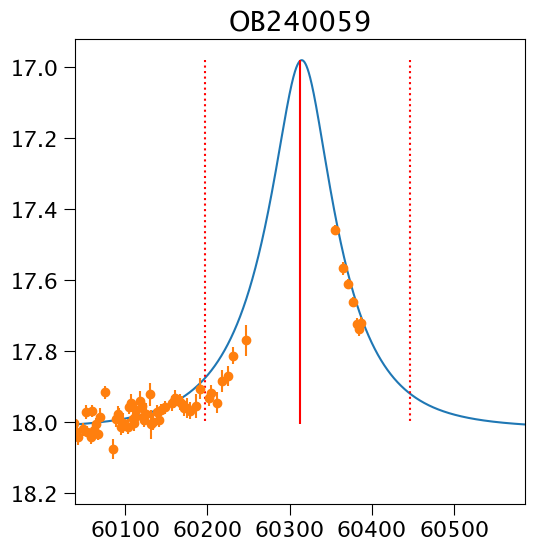

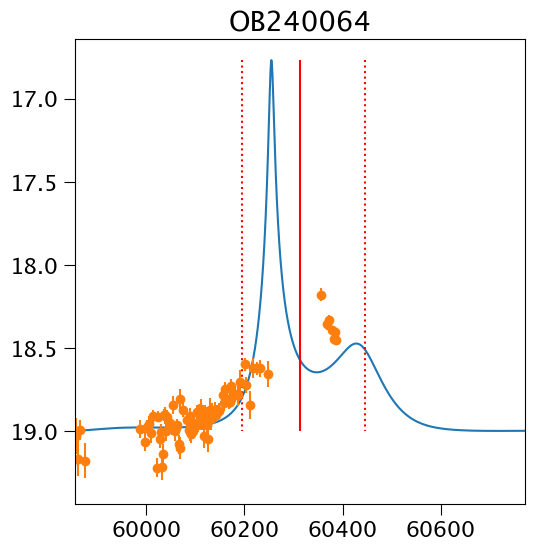

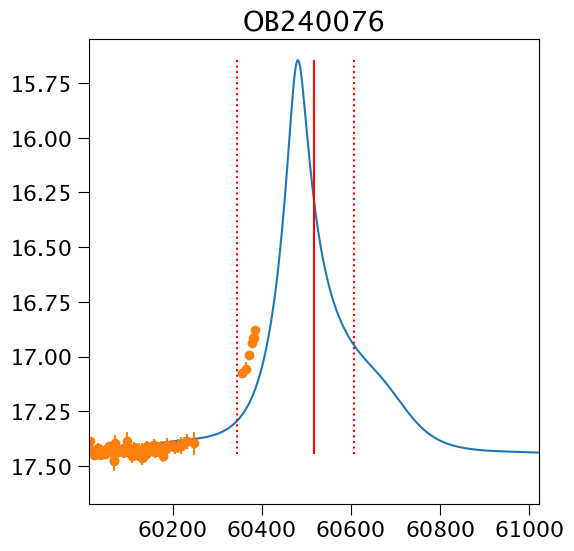

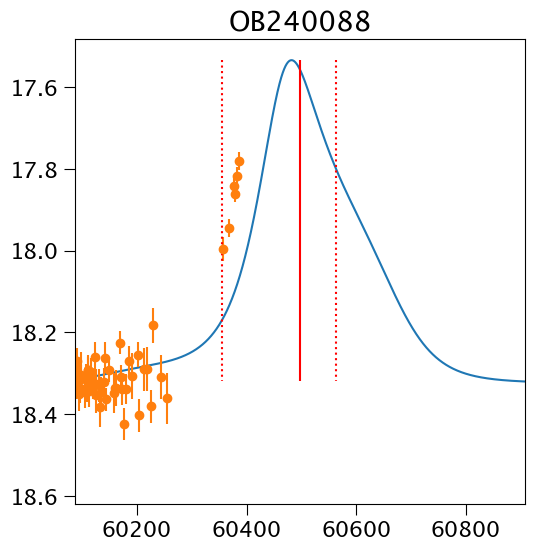

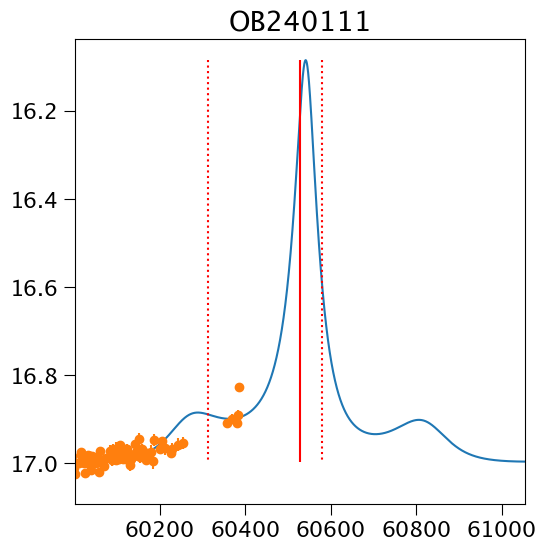

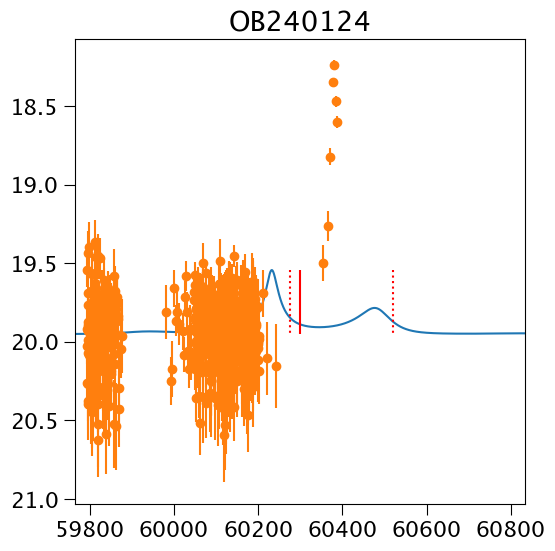

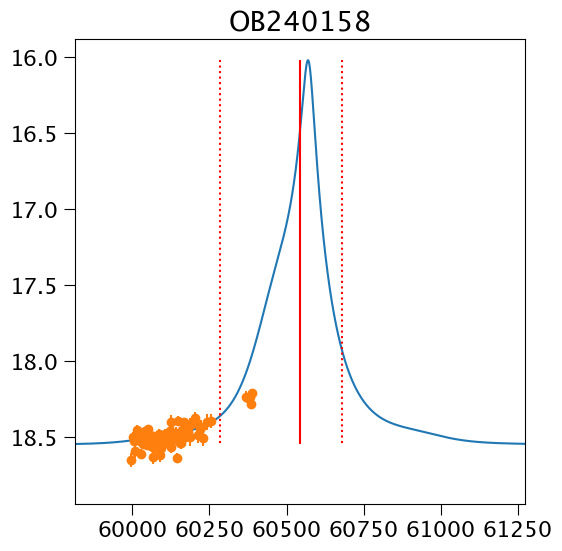

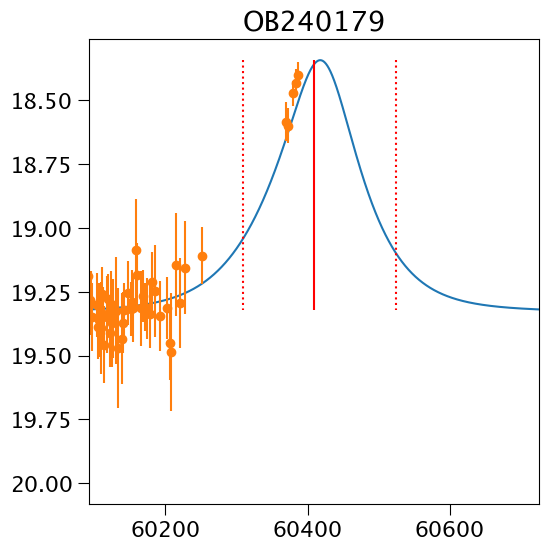

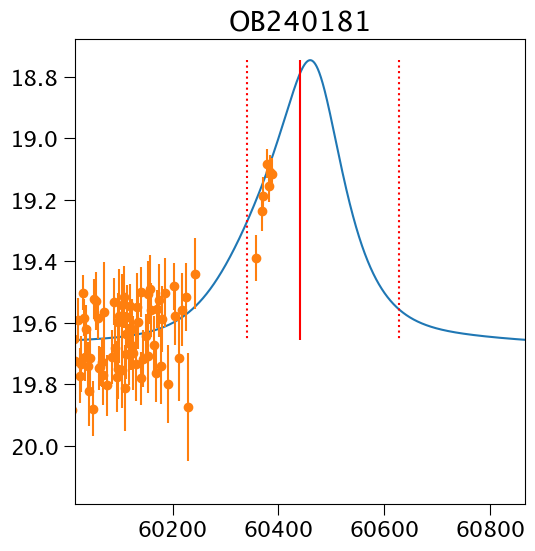

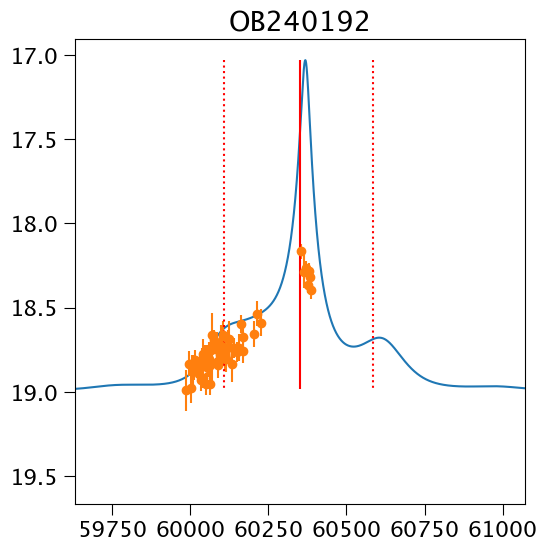

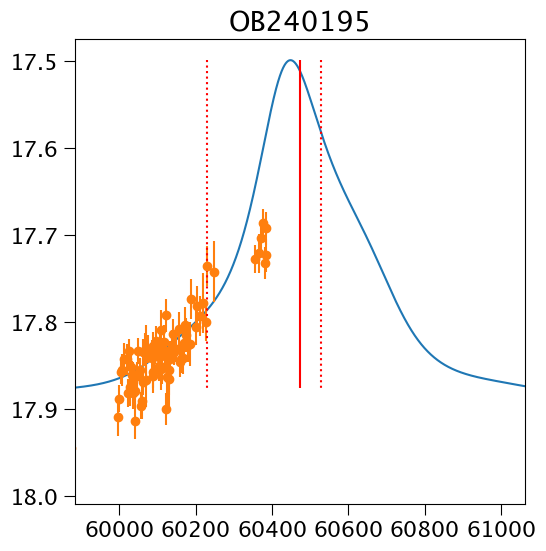

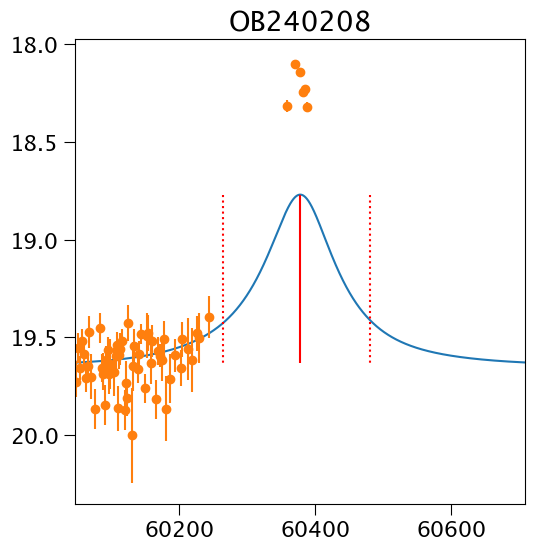

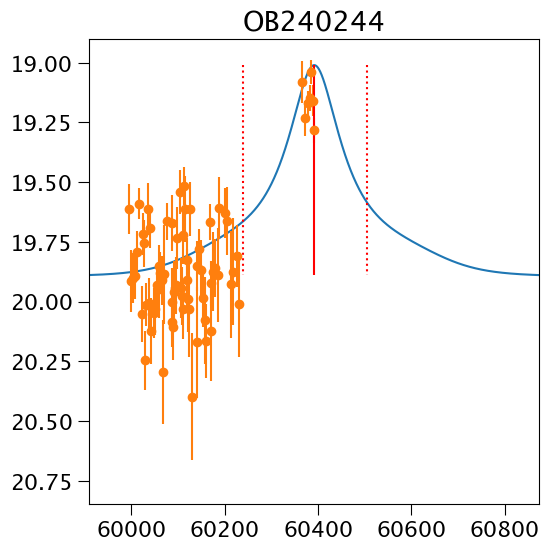

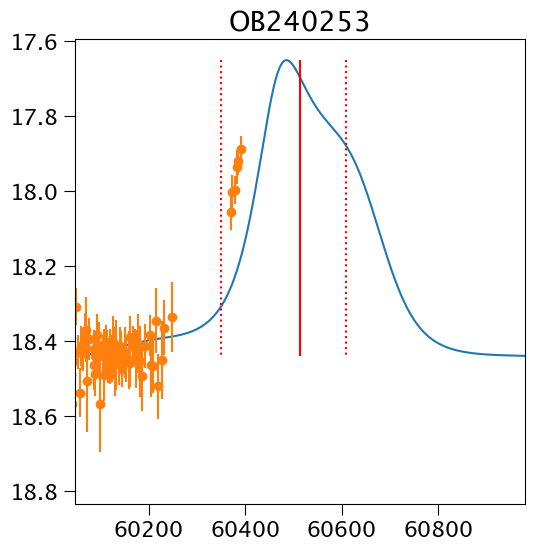

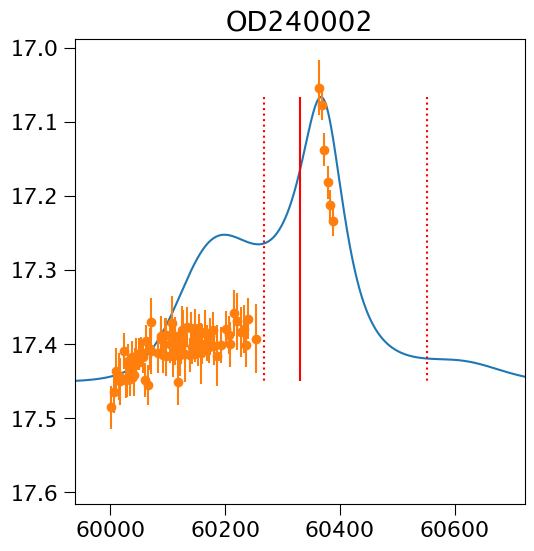

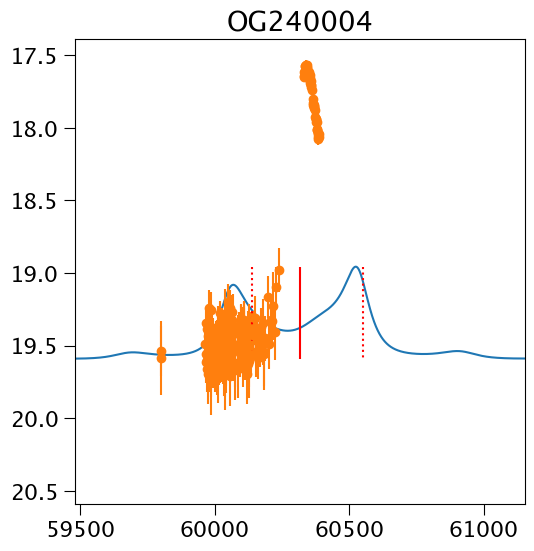

In [151]:
for i,event in enumerate(events):
    if event[0]=='O':
        plt.figure()
        #dir = event+'/fits_'+date+'/pspl_phot_par/'
        phot_type = list(jdat['data_sets'][event].values())[0]
        datfile = '../'+jdat[phot_type][event]
        t_obs,mag_obs,err_obs = np.loadtxt(datfile,skiprows=1,delimiter=',', unpack=True)
        #print(t_obs)
        t_lims = [min(t_obs), max(t_obs)]
        t_range = np.arange(df['t0'][i]- 3*df['tE'][i], df['t0'][i]+3*df['tE'][i], 0.1)#np.arange(t_lims[0]-100, t_lims[1]+100, 0.1)
        mod = model.PSPL_Phot_Par_Param2(df['t0'][i], df['u0_amp'][i], df['tE'][i], df['piE_E'][i], df['piE_N'][i], df['b_sff1'][i], df['mag_base1'][i], 
                                         raL=jdat['ra'][event], decL=jdat['dec'][event])
        alertfit = {'t0':jdat['t0'][event], 'tE':jdat['tE'][event]}
        t0_priors = [alertfit['t0'] - alertfit['tE'], alertfit['t0'] + alertfit['tE']]
        #print(t0_priors)
        mag_mod = mod.get_photometry(t_range)
        plt.title(event+', mode 1 of'+str(df['nmodes'][i])
        plt.plot(t_range,mag_mod)
        plt.gca().invert_yaxis()
        plt.errorbar(t_obs,mag_obs,yerr=err_obs,  fmt='o')
        plt.vlines(df['t0'][i], min(mag_mod), max(mag_mod), colors='red')
        plt.vlines(t0_priors, min(mag_mod), max(mag_mod), colors='red', linestyles='dotted')
        plt.xlim(df['t0'][i]- 3*df['tE'][i], df['t0'][i]+3*df['tE'][i])